In [1]:
%run ./utility.ipynb

In [2]:
N = 64;  coeff = 1.e-9;  Breg = 10000.;  Nreg = 100.

"""
Make sure N and coeffs are same as mine
Coeff needs to change U,V smaller to fit in grid
In original code, U,Vs are power of 10^{10} and this scalling pushes them into -10 to 10
"""

# reading data
list_of_strings = []
with open('data', 'r') as f:
  for line in f:
    list_of_strings.append(line)
Na = len(list_of_strings) #-1 For mine because there is extra line 
UVa, sigma = np.zeros((2*Na, 2)), np.zeros(2*Na)
Oa = np.zeros(2*Na).astype(complex)
for a in range(Na):
  current_string = (list_of_strings[-1]).split(" ") # Split on commas
  list_of_strings.pop()
  UVa[a, 0], UVa[a, 1] = float(current_string[3]), float(current_string[4])
  Oa[a] = float(current_string[5])*np.exp(1j*float(current_string[6])*np.pi/180.)
  sigma[a] = float(current_string[7])
  UVa[a + Na], Oa[a + Na], sigma[a + Na] = -UVa[a], np.conj(Oa[a]), sigma[a]
del list_of_strings, current_string

# local cubic interpolation
def cubf1(x, y):                              #      8  11
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)   #   8  2  3  10
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)   #   4  0  1  6
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)    #      5  7
def cubf2(x, y):  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
IND = np.array([[-2, -2], [-1, -2], [-2, -1], [-1, -1], [-3, -2], [-2, -3], \
  [0, -2], [-1, -3], [-3, -1], [-2, 0], [0, -1], [-1, 0]]).astype(int)
def cubfun12(x, y):  return np.array([cubf1(x, y), cubf1(1. - x, y), \
    cubf1(x, 1. - y), cubf1(1. - x, 1. - y), cubf2(x, y), cubf2(y, x), \
    cubf2(1. - x, y), cubf2(y, 1. - x), cubf2(x, 1. - y), cubf2(1. - y, x), \
    cubf2(1. - x, 1. - y), cubf2(1. - y, 1. - x)])

"""
Calculate DO
Compare G = -2DO
"""

# computing DO, the dirty image from observations
DOuv = np.zeros((N, N)).astype(complex)
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = Oa[a] / sigma[a]**2, cubfun12(x, y)
  for c in range(12):  DOuv[m1 + IND[c, 0], m2 + IND[c, 1]] += C*CUBFUN[c]
DO = N*np.real(np.fft.ifft2(DOuv))
del DOuv

# computing DK, the dirty kernel
DK49, DK = np.zeros((N, N, 7, 7)), []
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = 1. / sigma[a]**2, cubfun12(x, y)
  for c in range(12):
    for cp in range(12):
      DK49[m1 + IND[c, 0], m2 + IND[c, 1], 3 + IND[cp, 0] - IND[c, 0], \
           3 + IND[cp, 1] - IND[c, 1]] += CUBFUN[c]*CUBFUN[cp]*C
for u in range(N):
  for v in range(N):
    for du in range(7):
      for dv in range(7):
        if (DK49[u, v, du, dv] != 0.):
          DK.append([u, v, ((u + du) % N) - 3, ((v + dv) % N) - 3, \
            DK49[u, v, du, dv]])
del DK49, IND, CUBFUN

# computing DI, the dirtying of the image I
I12, Iuv = np.zeros((2, N, N)), np.zeros((N, N)).astype(complex)
DI, DIuv = np.zeros((N, N)), np.zeros((N, N)).astype(complex)
def calc_DI():
  global Iuv, DI, DIuv
  Iuv, DIuv = np.fft.fft2(I), np.zeros((N, N)).astype(complex)
  for q in DK:  DIuv[q[0], q[1]] += q[4]*Iuv[q[2], q[3]]
  DI = np.real(np.fft.ifft2(DIuv))
  return

# computing G, the gradient of the loss function
def neighbor(Iat, Inear):  return np.sign(Iat - Inear)
def calc_G():
  global G
  calc_DI()
  G = 2.*(DI - DO)
#  G = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if (I[i, j] < 0.):  G[i, j] -= Breg
      if (I[i, j] > 0.):  G[i, j] += Nreg
#      G[i, j] += Breg*neighbor(I[i, j], 0.)
#      G[i, j] += Nreg*neighbor(I[i, j], I[i - 1, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, j - 1])
#      G[i, j] += Nreg*neighbor(I[i, j], I[(i + 1) % N, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, (j + 1) % N])
  return

I, dt = (0.*DO), 0.00001
for it in range(4000):
#  print(it)
  calc_G()
  I -= dt*G

#calc_DI()
for i in range(N):
  for j in range(N):
#    print(I[i, j], ' ', end='')
    print(DI[i, j] - DO[i, j], ' ', end='')
  print('')


IsADirectoryError: [Errno 21] Is a directory: 'data'

In [3]:
import numpy as np
N = 80;  coeff = 4.84813681109536e-10;  Breg = 10000.;  Nreg = 100.

"""
coeff investigate! Something along the lines of FOV/#ofpixels
"""

# reading data
list_of_strings = []
with open('./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv', 'r') as f:
  for line in f:
    list_of_strings.append(line)
list_of_strings.pop(0)
Na = len(list_of_strings) #-1 For mine because there is extra line 
print(len(list_of_strings))
UVa, sigma = np.zeros((2*Na, 2)), np.zeros(2*Na)
Oa = np.zeros(2*Na).astype(complex)
for a in range(Na):
  current_string = (list_of_strings[-1]).split(",") # Split on commas
  list_of_strings.pop()
  UVa[a, 0], UVa[a, 1] = float(current_string[3]), float(current_string[4])
  Oa[a] = float(current_string[5])*np.exp(1j*float(current_string[6])*np.pi/180.)
  sigma[a] = float(current_string[7])
  UVa[a + Na], Oa[a + Na], sigma[a + Na] = -UVa[a], np.conj(Oa[a]), sigma[a]
del list_of_strings, current_string

# local cubic interpolation
def cubf1(x, y):                              #      8  11
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)   #   8  2  3  10
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)   #   4  0  1  6
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)    #      5  7
def cubf2(x, y):  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
IND = np.array([[-2, -2], [-1, -2], [-2, -1], [-1, -1], [-3, -2], [-2, -3], \
  [0, -2], [-1, -3], [-3, -1], [-2, 0], [0, -1], [-1, 0]]).astype(int)
def cubfun12(x, y):  return np.array([cubf1(x, y), cubf1(1. - x, y), \
    cubf1(x, 1. - y), cubf1(1. - x, 1. - y), cubf2(x, y), cubf2(y, x), \
    cubf2(1. - x, y), cubf2(y, 1. - x), cubf2(x, 1. - y), cubf2(1. - y, x), \
    cubf2(1. - x, 1. - y), cubf2(1. - y, 1. - x)])

"""
Calculate DO
Compare G = -2DO
"""

# computing DO, the dirty image from observations
DOuv = np.zeros((N, N)).astype(complex)
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = Oa[a] / sigma[a]**2, cubfun12(x, y)
  for c in range(12):  DOuv[m1 + IND[c, 0], m2 + IND[c, 1]] += C*CUBFUN[c]
DO = N*np.real(np.fft.ifft2(DOuv))
del DOuv

# computing DK, the dirty kernel
DK49, DK = np.zeros((N, N, 7, 7)), []
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = 1. / sigma[a]**2, cubfun12(x, y)
  for c in range(12):
    for cp in range(12):
      DK49[m1 + IND[c, 0], m2 + IND[c, 1], 3 + IND[cp, 0] - IND[c, 0], \
           3 + IND[cp, 1] - IND[c, 1]] += CUBFUN[c]*CUBFUN[cp]*C
for u in range(N):
  for v in range(N):
    for du in range(7):
      for dv in range(7):
        if (DK49[u, v, du, dv] != 0.):
          DK.append([u, v, ((u + du) % N) - 3, ((v + dv) % N) - 3, \
            DK49[u, v, du, dv]])
del DK49, IND, CUBFUN

# computing DI, the dirtying of the image I
I12, Iuv = np.zeros((2, N, N)), np.zeros((N, N)).astype(complex)
DI, DIuv = np.zeros((N, N)), np.zeros((N, N)).astype(complex)
def calc_DI():
  global Iuv, DI, DIuv
  Iuv, DIuv = np.fft.fft2(I), np.zeros((N, N)).astype(complex)
  for q in DK:  DIuv[q[0], q[1]] += q[4]*Iuv[q[2], q[3]]
  DI = np.real(np.fft.ifft2(DIuv))
  return

# computing G, the gradient of the loss function
def neighbor(Iat, Inear):  return np.sign(Iat - Inear)
def calc_G():
  global G
  calc_DI()
  G = 2.*(DI - DO)
#  G = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if (I[i, j] < 0.):  G[i, j] -= Breg
      if (I[i, j] > 0.):  G[i, j] += Nreg
#      G[i, j] += Breg*neighbor(I[i, j], 0.)
#      G[i, j] += Nreg*neighbor(I[i, j], I[i - 1, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, j - 1])
#      G[i, j] += Nreg*neighbor(I[i, j], I[(i + 1) % N, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, (j + 1) % N])
  return

I, dt = (0.*DO), 0.00001
#for it in range(4000):
#  print(it)
#  calc_G()
#  I -= dt*G

calc_DI()
for i in range(N):
  for j in range(N):
#    print(I[i, j], ' ', end='')
    print(DO[i, j], ' ', end='')
  print('')


6458
58323.23350943204  64183.049640411664  70342.19688473325  76463.96037976317  82220.16597132056  87305.73622052035  91452.51766566507  94441.89074861264  96115.64259028548  96384.5643224987  95234.24157287803  92727.55055779137  89003.46182561584  84271.8933431409  78804.5430845263  72921.86116885504  66976.57946460739  61334.483778300266  56353.36785037754  52361.32520517919  49635.69081987981  48384.01898300869  48728.46133707091  50694.78195464391  54207.015032441996  59088.44528819557  65069.190279815084  71800.21437073575  78873.13862691575  85844.76562534264  92264.8494482344  97705.34272347736  101789.17231835447  104216.55259778662  104786.94895689753  103415.05197293212  100139.49958876801  95123.56595481075  88647.58658445961  81093.4695900302  72922.20808565989  64645.81592598703  56795.518366710385  49888.30886180076  44394.1109272239  40705.74954130665  39113.742389092025  39787.58239324253  42764.72567910187  47947.95873747794  55111.2365366803  63913.503840376696  73

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'coeff = 1/1/FOV')

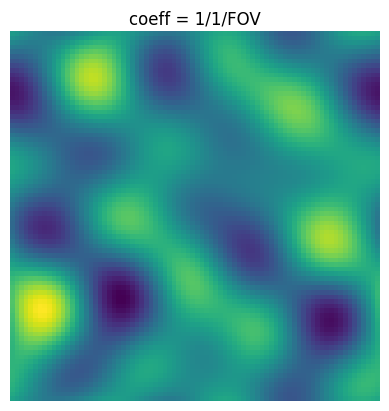

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(-2*DO)
plt.axis('off')
plt.title("coeff = 1/1/FOV")

In [5]:
DO*-2

array([[-116646.46701886, -128366.09928082, -140684.39376947, ...,
         -91450.36137387,  -97604.69567073, -106186.35145086],
       [-138537.23292684, -148204.82462109, -157794.7652918 , ...,
        -115304.9269417 , -121493.42134959, -129427.59623139],
       [-163392.59251285, -170682.55206445, -177182.57787896, ...,
        -142739.95793684, -148831.0151472 , -155908.1235502 ],
       ...,
       [ -71452.00291781,  -85951.04615815, -102778.16949163, ...,
         -47574.13502774,  -51811.69612689,  -59900.60162317],
       [ -83028.56233307,  -97288.87660565, -113356.05239048, ...,
         -57187.30715375,  -62463.2062898 ,  -71230.17751531],
       [ -98086.4991984 , -111382.34285623, -125907.29665289, ...,
         -71906.2759915 ,  -77790.35180406,  -86687.95278649]])

In [17]:
print("Max:", np.max(G2/(2*DO)))
print("Min:", np.min(G2/(2*DO)))
(G2/40) + 2*DO

Max: 10634.12497068253
Min: -4698.549864963042


array([[ 1.88685869e-02,  9.77498997e-01,  3.06661933e+01, ...,
        -1.81330529e+02, -6.57849382e+01, -1.12813984e+01],
       [-1.13237884e+01,  1.70792586e+01,  1.00051148e+02, ...,
        -8.85570696e+01, -3.47589665e+01, -1.74406418e+01],
       [-2.19602950e+01,  5.57906727e+01,  2.14701847e+02, ...,
        -3.39813598e+01, -3.54408548e+01, -4.16646179e+01],
       ...,
       [-2.48380060e+02, -2.11127962e+02, -2.07965097e+02, ...,
        -8.37800540e+02, -5.59682861e+02, -3.59349655e+02],
       [-9.98005610e+01, -9.00720978e+01, -9.73097466e+01, ...,
        -5.56918333e+02, -3.21709500e+02, -1.69164753e+02],
       [-2.12466725e+01, -2.54996309e+01, -2.55644666e+01, ...,
        -3.35196089e+02, -1.56597946e+02, -5.51803561e+01]])

In [6]:
G1 = np.loadtxt("./gradient_2.txt", delimiter=",")
G2 = np.loadtxt("./gradient.txt", delimiter=",")

In [16]:
np.max(np.abs(G1-2*DO))

8802554.866777098

In [14]:
np.max(np.abs(G2+2*DO))

15281490.19124386

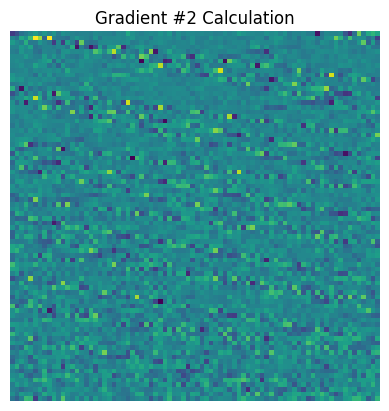

In [21]:
plt.figure()
plt.imshow(G1)
plt.axis('off')
plt.title("Gradient #2 Calculation")
plt.savefig("G1.png")

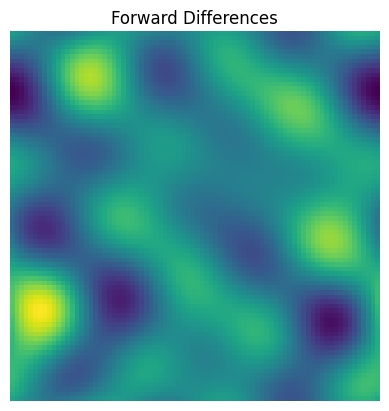

In [20]:
plt.figure()
plt.imshow(G2)
plt.axis('off')
plt.title("Forward Differences")
plt.savefig("G2.png")